# Discrete-Time Volatility Forecasting WithPersistent Leverage Effect and the Link With Continuous-Time Volatility Modeling 
## Fulvio Corsi & Roberto Renò

### Abstract
Wefirst propose a reduced-form model in discrete time for S&P 500 volatility showing that the forecasting
performance can be significantly improved by introducing a persistent leverage effect with a long-range
dependence similar to that of volatility itself. We also find a strongly significant positive impact of lagged
jumps onvolatility, which however is absorbed more quickly. We then estimate continuous-time stochastic
volatility models that are able to reproduce the statistical features captured by the discrete-time model. We
showthatasingle-factor model driven byafractional Brownian motionisunabletoreproducethevolatility
dynamics observed in the data, while a multifactor Markovian model fully replicates the persistence of
both volatility and leverage effect. The impact of jumps can be associated with a common jump component
in price and volatility. This article has online supplementary materials.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import savemat, loadmat
import subprocess
import os
import sys
import datetime

In [3]:
from python_scripts.LHAR_CJ import fit_lharcj
from python_scripts.helpers import set_datetime_index_and_solve_duplicates

## 1. Load data
Choose 1 stocks from the list below:


In [4]:
financial_stocks = ['CRDI_MI', 'ISP_MI', 'BAMI_MI', 'BMED_MI', 'BCU_MI', 'FBK_MI', 'BMPS_MI']

In [5]:
stock = 'ISP_MI' 

In [6]:
root_folder = f"D:/stockData/FTSE_MIB_stocks_merged/"
df = pd.read_parquet(root_folder+stock+'.parquet')
price = set_datetime_index_and_solve_duplicates(df, stock)
display(price)

DateTime
2014-01-02 08:00:52.066059    1.804
2014-01-02 08:00:52.286689    1.805
2014-01-02 08:00:52.316015    1.805
2014-01-02 08:00:52.326749    1.805
2014-01-02 08:00:52.336496    1.805
                              ...  
2025-07-04 15:35:03.341325    4.868
2025-07-04 15:35:03.346643    4.868
2025-07-04 15:35:34.121827    4.868
2025-07-04 15:35:35.306576    4.868
2025-07-04 15:35:45.951905    4.868
Name: ISP_MI, Length: 23733070, dtype: float64

## 2. Fit LHAR-CJ

### The LHAR-CJ Model

The **LHAR-CJ (Log-Heterogeneous Autoregressive model with Continuous and Jump components)** is an extension of the HAR model introduced by Corsi (2009), developed in  
**Corsi & Renò (2012)** to explicitly account for **jumps** and **leverage effects** in volatility dynamics.

The model is specified in terms of **log-integrated variance** and decomposes volatility into:
- a **continuous component**,
- a **jump component**,
- and a **return-based leverage term**.

---

### Integrated Variance (IV)

Let the log-price process be
$$
dp_t = \mu_t \, dt + \sigma_t \, dW_t + dJ_t,
$$
where $J_t$ is a jump process.

The **integrated variance** over day $t$ is defined as
$$
IV_t = \int_{t-1}^{t} \sigma_s^2 \, ds.
$$

In the presence of **market microstructure noise**, the integrated variance is estimated using the  
**Two-Scales Realized Variance (TSRV)** estimator.

---
### LHAR-CJ Specification

The LHAR-CJ regression model is:
$$
\log(IV_t)
=
\alpha
+ \beta_d \log(C_{t-1})
+ \beta_w \log(C_{t-1:t-5})
+ \beta_m \log(C_{t-1:t-22})
+ \gamma \log(1 + J_{t-1})
+ \delta r_{t-1}
+ \varepsilon_t.
$$

Where:
- daily, weekly and monthly averages capture **heterogeneous persistence**,
- the jump term captures **discontinuous risk**,
- the return term captures **leverage**.

---

### Two-Scales Realized Variance (TSRV)

Observed prices are contaminated by noise:
$$
Y_{t_i} = X_{t_i} + \varepsilon_{t_i}.
$$

The standard realized variance is upward biased.  
The **TSRV estimator** corrects this bias by combining:
- realized variance on the full grid,
- realized variances on sparse sub-grids.

Formally,
$$
\widehat{IV}^{TSRV}
=
\overline{RV}^{(K)} - \frac{\bar{n}}{n} RV^{(all)},
$$
where:
- $K \sim n^{2/3}$ is the subsampling frequency,
- $\overline{RV}^{(K)}$ is the average realized variance across sub-grids,
- $RV^{(all)}$ is the realized variance on the full grid.

This estimator is **consistent** for integrated variance in the presence of noise.

---

### Continuous Variation (C)

The **continuous component** of volatility is estimated using the  
**Realized Bipower Variation (RBV)**:
$$
C_t = \frac{\pi}{2} \sum_{i=2}^{n} |r_{t,i}| \, |r_{t,i-1}|,
$$
where $r_{t,i}$ are intraday log-returns.

RBV is **robust to finite-activity jumps** and consistently estimates the continuous part of quadratic variation.

---

### Jump Component (J)

The **jump variation** is defined as the difference between total and continuous variation:
$$
J_t = \max(IV_t - C_t, 0).
$$

This construction isolates volatility due to **price jumps**.

---

### Daily Return (r)

The daily log-return is computed from intraday prices as
$$
r_t = \log P_t^{close} - \log P_t^{open}.
$$

It captures **leverage effects**, i.e. the asymmetric impact of returns on future volatility.

---



### Summary of Components

| Symbol | Meaning | Estimator |
|------|--------|-----------|
| $IV_t$ | Integrated variance | TSRV |
| $C_t$ | Continuous variation | RBV |
| $J_t$ | Jump variation | $IV_t - C_t$ |
| $r_t$ | Daily return | Open-to-close log-return |

---

The LHAR-CJ model provides a flexible and economically interpretable framework that links  
**high-frequency volatility estimation** with **discrete-time volatility forecasting**.


In [7]:
res = fit_lharcj(price=price)
res['beta_ols']

const        -2.572116
logC_d        0.444794
logC_w        0.250970
logC_m        0.054827
log1pJ_d    777.254030
r_d          -4.894817
Name: beta_ols, dtype: float64

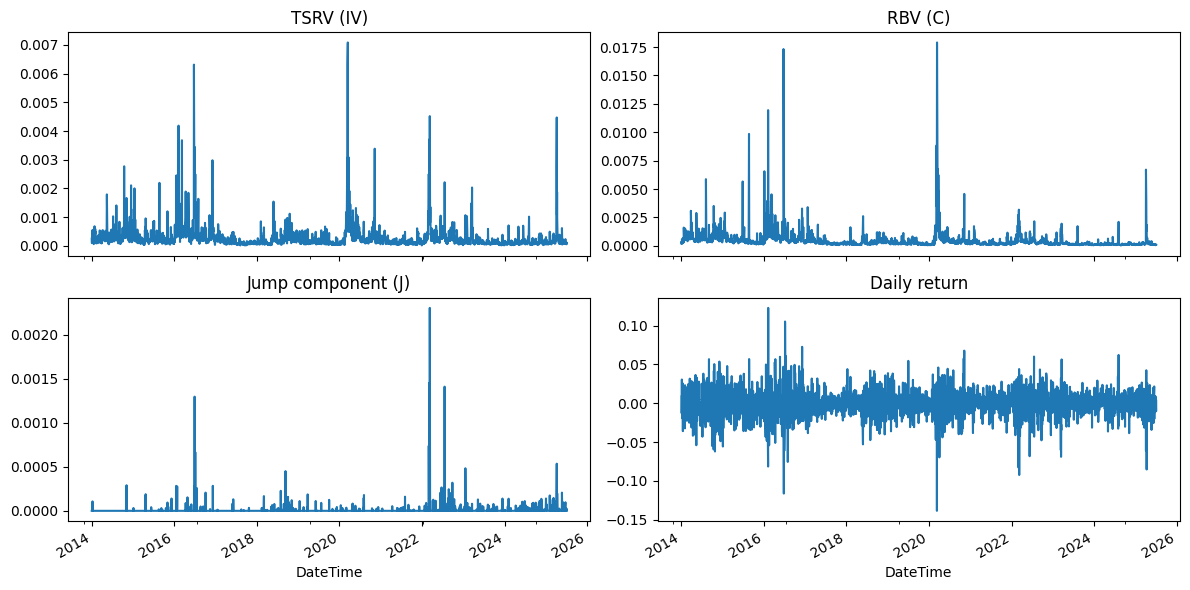

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

res["IV"].plot(ax=axes[0, 0])
axes[0, 0].set_title("TSRV (IV)")

res["C"].plot(ax=axes[0, 1])
axes[0, 1].set_title("RBV (C)")

res["J"].plot(ax=axes[1, 0])
axes[1, 0].set_title("Jump component (J)")

res["r"].plot(ax=axes[1, 1])
axes[1, 1].set_title("Daily return")

plt.tight_layout()
plt.show()


In [25]:
# Save coefficients and matrix

out_dir = Path(r"results")
out_dir.mkdir(parents=True, exist_ok=True)

n_days = res['nobs']
beta_real = res["beta_ols"].to_numpy().reshape(-1,1)
VCV_real = res["vcov_hac"]
beta_names = np.array(res["beta_ols"].index.tolist(), dtype=object)


savemat(out_dir / "real_beta_vcv.mat", {
    "beta_real": beta_real,
    "VCV_real": VCV_real,
    "beta_names": beta_names,
    "n_days": int(n_days),
})

## Indirect Inference

### Indirect Inference and the Role of LHAR-CJ

### Motivation

In many continuous-time financial models, such as the **Heston stochastic volatility model**,  
the **likelihood function is either unavailable or numerically intractable** when the model is confronted with high-frequency data and complex dependence structures.

**Indirect Inference (II)** provides a simulation-based estimation framework that avoids direct likelihood evaluation by exploiting a simpler, yet informative, **auxiliary model**.

---

### The Heston Model

The (one-factor) Heston model is defined as:
$$
\begin{aligned}
dS_t &= \mu S_t \, dt + \sqrt{v_t} S_t \, dW_t^S, \\
dv_t &= \kappa (\theta - v_t) \, dt + \sigma \sqrt{v_t} \, dW_t^v, \\
d\langle W^S, W^v \rangle_t &= \rho \, dt.
\end{aligned}
$$

The parameter vector is:
$$
\theta = (\kappa, \theta, \sigma, \rho).
$$

Although the model is defined in continuous time, **observed volatility dynamics are measured in discrete time** and are contaminated by microstructure noise and jumps.

---

### Indirect Inference: Basic Idea

Indirect inference proceeds in three main steps:

1. **Estimate an auxiliary model on real data**
   $$\hat{\beta}^{\,data}.$$

2. **Simulate data from the structural model** (Heston) for a given parameter vector $\theta$, and estimate the same auxiliary model on the simulated data:
   $$\hat{\beta}^{\,sim}(\theta).$$

3. **Choose $\theta$ to minimize a distance between the two estimates**:
   $$
   \hat{\theta}
   =
   \arg\min_{\theta}
   \left(
   \hat{\beta}^{\,data} - \hat{\beta}^{\,sim}(\theta)
   \right)^\top
   W
   \left(
   \hat{\beta}^{\,data} - \hat{\beta}^{\,sim}(\theta)
   \right),
   $$
   where $W$ is a positive definite weighting matrix.

---

### Monte Carlo Approximation

Since $\hat{\beta}^{\,sim}(\theta)$ is random, it is approximated by Monte Carlo simulation:
$$
\bar{\beta}^{\,sim}(\theta)
=
\frac{1}{M}
\sum_{m=1}^{M}
\hat{\beta}^{(m)}(\theta).
$$

The objective function becomes:
$$
Q(\theta)
=
\left(
\hat{\beta}^{\,data} - \bar{\beta}^{\,sim}(\theta)
\right)^\top
W
\left(
\hat{\beta}^{\,data} - \bar{\beta}^{\,sim}(\theta)
\right).
$$

---

### Why LHAR-CJ as Auxiliary Model?

The **LHAR-CJ model** is an ideal auxiliary model for several reasons:

1. **Captures volatility persistence**  
   Daily, weekly and monthly components reproduce the long-memory behavior implied by stochastic volatility models.

2. **Separates continuous and jump variation**  
   The decomposition into $IV_t$, $C_t$ and $J_t$ allows the auxiliary model to react differently to diffusive and jump-driven volatility.

3. **Accounts for leverage effects**  
   The return term captures the correlation between returns and future volatility, directly linked to the Heston correlation parameter $\rho$.

4. **Easy and robust estimation**  
   LHAR-CJ can be estimated via OLS with HAC standard errors, even in the presence of heteroskedasticity and serial correlation.

5. **High identification power**  
   The coefficients of LHAR-CJ are highly informative about $(\kappa, \theta, \sigma, \rho)$.

---

### Interpretation

Indirect inference matches the **discrete-time volatility dynamics implied by the Heston model** to those observed in the data, without requiring explicit likelihood evaluation.

The LHAR-CJ coefficients act as **summary statistics** that transfer information from the data to the structural parameters.

---

### Summary

- The **structural model** is continuous-time (Heston).
- The **auxiliary model** is discrete-time (LHAR-CJ).
- Indirect inference bridges the two by matching auxiliary parameters.
- This approach is particularly suitable when:
  - likelihoods are intractable,
  - volatility is measured using high-frequency estimators,
  - jumps and leverage effects are present.



--------------------------------



### Run MATLAB code

Run **`matlab_indirect_inference/MAIN.m`** by running the following cell:


In [51]:
STOP = True

if STOP:
    sys.exit()

SystemExit: 

c:\Users\alber\python_projects\IndirectInference\venv_fundamentals\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
matlab_exe = r"D:\matlab\bin\matlab.exe"
project_root = Path.cwd() 
matlab_dir = project_root / "matlab_indirect_inference"
cmd = f"cd('{matlab_dir.as_posix()}'); MAIN"

subprocess.run([matlab_exe, "-batch", cmd], check=True)
print("MATLAB run completed.")

------

In [28]:
# Save parameters in .csv file

m = loadmat(r"results\estimated_IF_LHAR_CJ_TSRV.mat")
kappa = m["kappa"].item()
theta = m["theta"].item()
sigma = m["sigma"].item()
rho   = m["rho"].item()

params = {
    "Ticker": stock,
    "kappa": float(kappa),
    "theta": float(theta),
    "sigma": float(sigma),
    "rho": float(rho),}

out_dir = Path("results")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = f"{out_dir}/{stock}_heston_indirect_inference.csv"

df_params = pd.DataFrame([params])
df_params.to_csv(out_path, index=False)

print(f'Parameters saved in {out_path}\n')
print(f"kappa: {kappa}\n theta: {theta}\n sigma: {sigma}\n rho: {rho}")

Parameters saved in results/ISP_MI_heston_indirect_inference.csv

kappa: 0.06270430672512983
 theta: 0.7573868774703332
 sigma: 1.3124360925819223
 rho: 0.9999975053322889


### 4. Price an option

In [ ]:
from python_scripts.pricing import heston_call_price

In [46]:
def load_params(stock: str) -> list[float]:
    data = pd.read_csv(f"results\\{stock}_heston_indirect_inference.csv")
    return data.iloc[0]

In [50]:
a = load_params(stock)
a

Ticker      ISP_MI
kappa     0.062704
theta     0.757387
sigma     1.312436
rho       0.999998
Name: 0, dtype: object